In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
file_path = "Resources/hawaii.sqlite"
engine = create_engine(f'sqlite:///{file_path}', echo=False)

In [6]:
print(file_path)

Resources/hawaii.sqlite


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

# Exploratory Climate Analysis

In [11]:
columns = inspector.get_columns('measurement')
columns

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [12]:
columns = inspector.get_columns('station')
columns

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [13]:
#engine.execute('SELECT max(date) FROM measurement').fetchall()

last_date = session.query(func.max(Measurement.date)).all()
last_date

[('2017-08-23')]

<AxesSubplot:xlabel='Date', ylabel='Inches'>

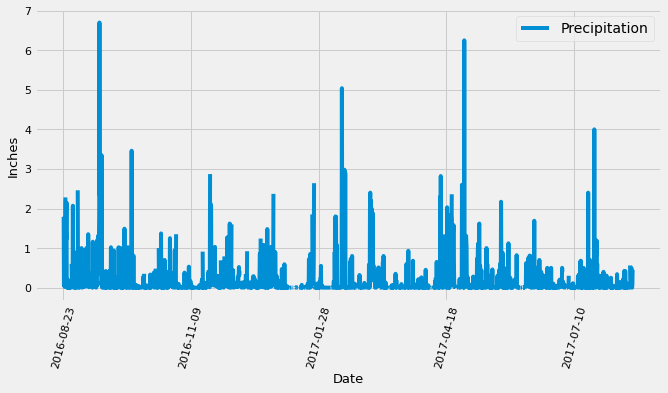

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date=dt.date(2017, 8, 23)
prev_year=last_date-dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date>=prev_year, Measurement.date<=last_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

results_df=pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

sorted_results = results_df.sort_values(by='Date')
sorted_results.head()
# Use Pandas Plotting with Matplotlib to plot the data
barplot = sorted_results.plot(x='Date', y='Precipitation', fontsize=11, figsize=(10,5))
plt.xticks(rotation=75, fontsize = 11)
plt.xlabel('Date', fontsize= 13)
plt.ylabel('Inches',fontsize= 13)
barplot

In [15]:
## Use Pandas to calcualte the summary statistics for the precipitation data

sorted_results.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
number_st = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {number_st} stations available.") 




There are 9 stations available.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_st = session.query(Measurement.station, func.count(Measurement.id))\
                    .group_by(Measurement.station)\
                    .order_by(func.count('*').desc()).limit(1).all()
active_st


[('USC00519281', 2772)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_281 = session.query(Measurement.station , func.min(Measurement.tobs),\
                                                  func.max(Measurement.tobs),\
                                                  func.round(func.avg(Measurement.tobs))\
                           ).\
filter(Measurement.station == 'USC00519281', Measurement.tobs).all()

station_281


[('USC00519281', 54.0, 85.0, 72.0)]

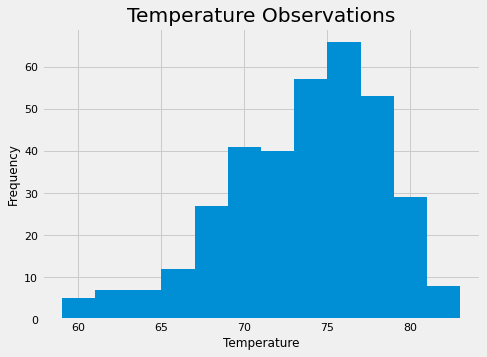

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_date=dt.date(2017, 8, 23)
prev_year=last_date-dt.timedelta(days=365)


results_2=session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281',\
                       Measurement.date>=prev_year,\
                       Measurement.date<=last_date).all()

results_2_df = pd.DataFrame(results_2)
results_2_df.head()


results_2_df.hist(bins=12, figsize=(7,5))
plt.xlabel('Temperature', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.title("Temperature Observations")
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-06-06', '2017-06-12'))

[(72.0, 77.24444444444444, 83.0)]


In [21]:
# calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
last_date=dt.date(2017, 8, 23)
first_date=dt.timedelta(2012, 1, 1)
  
    
result_tobs = session.query(Measurement.date, func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs)), func.max(Measurement.tobs)).\
              filter(Measurement.date >= first_date).\
              filter(Measurement.date <= last_date).\
              filter(func.strftime("%m-%d", Measurement.date) >= '06-06').\
              filter(func.strftime("%m-%d", Measurement.date) <= '06-12').\
              group_by(Measurement.date).all()
result_tobs
# function usage example


[('2010-06-06', 73.0, 76.0, 79.0),
 ('2010-06-07', 69.0, 74.0, 77.0),
 ('2010-06-08', 71.0, 76.0, 79.0),
 ('2010-06-09', 72.0, 76.0, 80.0),
 ('2010-06-10', 72.0, 76.0, 79.0),
 ('2010-06-11', 75.0, 78.0, 83.0),
 ('2010-06-12', 70.0, 75.0, 78.0),
 ('2011-06-06', 70.0, 74.0, 77.0),
 ('2011-06-07', 68.0, 72.0, 77.0),
 ('2011-06-08', 72.0, 74.0, 77.0),
 ('2011-06-09', 71.0, 75.0, 77.0),
 ('2011-06-10', 71.0, 75.0, 79.0),
 ('2011-06-11', 71.0, 76.0, 78.0),
 ('2011-06-12', 69.0, 75.0, 82.0),
 ('2012-06-06', 70.0, 73.0, 76.0),
 ('2012-06-07', 71.0, 74.0, 78.0),
 ('2012-06-08', 73.0, 75.0, 77.0),
 ('2012-06-09', 73.0, 75.0, 77.0),
 ('2012-06-10', 73.0, 76.0, 81.0),
 ('2012-06-11', 69.0, 74.0, 79.0),
 ('2012-06-12', 72.0, 76.0, 77.0),
 ('2013-06-06', 72.0, 76.0, 79.0),
 ('2013-06-07', 71.0, 74.0, 77.0),
 ('2013-06-08', 74.0, 77.0, 81.0),
 ('2013-06-09', 71.0, 76.0, 79.0),
 ('2013-06-10', 72.0, 75.0, 78.0),
 ('2013-06-11', 72.0, 75.0, 77.0),
 ('2013-06-12', 72.0, 76.0, 81.0),
 ('2014-06-06', 70.0

In [22]:
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(result_tobs, columns = ['Date','TMIN', 'TAVG', 'TMAX'])

last_date=dt.date(2017, 8, 23)
first_date=dt.timedelta(2010, 1, 1)
  
    
result_ptps = session.query(func.max(Measurement.tobs) - func.min(Measurement.tobs)).\
              filter(Measurement.date >= first_date).\
              filter(Measurement.date <= last_date).\
              filter(func.strftime("%m-%d", Measurement.date) >= '06-06').\
              filter(func.strftime("%m-%d", Measurement.date) <= '06-12').\
              group_by(Measurement.date).all()

ptps = list(np.ravel(result_ptps))




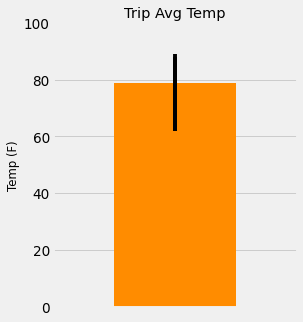

In [23]:
# Create a error bar chart
xpos = 1
yerror = ptps

w = 4
h = 5
d = 70

plt.figure(figsize=(w, h), dpi=d)
plt.bar(xpos, df.TAVG , yerr=yerror, color='darkorange', width=4)
plt.xlim(-3,5)
plt.title("Trip Avg Temp", fontsize = 15)
plt.ylabel("Temp (F)", fontsize=12)
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
last_date=dt.date(2017, 8, 23)
first_date=dt.timedelta(2010, 1, 1)

sel = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
rainfall=session.query(*sel).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
              filter(Measurement.date >= first_date).\
              filter(Measurement.date <= last_date).\
              filter(func.strftime("%m-%d", Measurement.date) >= '06-06').\
              filter(func.strftime("%m-%d", Measurement.date) <= '06-12').\
    order_by(func.count(Measurement.prcp).desc()).all()
for r in rainfall:
    print(r)


(56, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(56, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(54, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(54, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(49, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(41, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(36, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(15, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# Calculate min, max, avg for the trip dates chosen

last_date=dt.date(2017, 8, 23)
first_date=dt.timedelta(2010, 1, 1)
  
    
result_tobs = session.query(Measurement.date, func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs)), func.max(Measurement.tobs)).\
              filter(Measurement.date >= first_date).\
              filter(Measurement.date <= last_date).\
              filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2017-06-06').\
              filter(func.strftime("%Y-%m-%d", Measurement.date) <= '2017-06-12').\
              group_by(Measurement.date).all()
result_tobs


[('2017-06-06', 74.0, 77.0, 80.0),
 ('2017-06-07', 75.0, 78.0, 81.0),
 ('2017-06-08', 75.0, 77.0, 80.0),
 ('2017-06-09', 72.0, 78.0, 81.0),
 ('2017-06-10', 72.0, 75.0, 78.0),
 ('2017-06-11', 73.0, 77.0, 81.0),
 ('2017-06-12', 74.0, 78.0, 83.0)]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_2 = pd.DataFrame(result_tobs, columns = ['Date','TMIN', 'TAVG', 'TMAX'])
df_2.set_index("Date", inplace =True)
df_2

,TMIN,TAVG,TMAX
Date,,,
2017-06-06,74.0,77.0,80.0
2017-06-07,75.0,78.0,81.0
2017-06-08,75.0,77.0,80.0
2017-06-09,72.0,78.0,81.0
2017-06-10,72.0,75.0,78.0
2017-06-11,73.0,77.0,81.0
2017-06-12,74.0,78.0,83.0


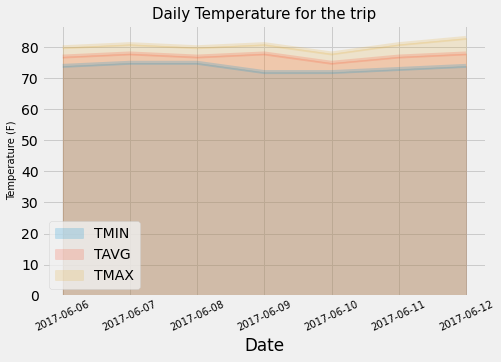

In [31]:
# Plot the DF as an area plot with `stacked=False`

df_2.plot.area(stacked=False, alpha = 0.2, rot=30, figsize=(7,5))

plt.tight_layout()
plt.xticks(rotation = 25, fontsize=10)

plt.tight_layout()
plt.ylabel("Temperature (F)", fontsize=10)
plt.title(f"Daily Temperature for the trip", fontsize=15)
plt.show()